In [ ]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from keras.layers.core import Reshape
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import datetime
import os
import cv2
import numpy
import random
import matplotlib

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In [ ]:
def lrelu_bn(inputs: Tensor) -> Tensor:
  lrelu = LeakyReLU()(inputs)
  bn = BatchNormalization()(lrelu)
  return bn

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def random_crop(image, width, height):
  for img in image:
    x = random.randint(0, img.shape[0] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[y: y+height, x: x+width]
  return image

def data_augmentation(image: Tensor) -> Tensor:
  image = (image / 255.0)
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def top_model(inputs: Tensor) -> Tensor:
  y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(inputs)
  y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(y)
  y = lrelu_bn(y)
  y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
  y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
  y = lrelu_bn(y)
  y_skip1 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
  y = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
  y = Add()([y_skip1, y])
  y = lrelu_bn(y)
  y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
  y = lrelu_bn(y)
  y_skip2 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
  y = Add()([y_skip2, y])
  y = lrelu_bn(y)
  y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
  y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
  y = lrelu_bn(y)
  y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
  y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
  y = lrelu_bn(y)
  return y

def bottom_model(inputs: Tensor, num_classes: int) -> Tensor:
  y = Flatten()(inputs)
  # y = Dense(4096, activation='relu')(y)
  # y = Dropout(0.2)(y)
  # y = Dense(4096, activation='relu')(y)
  # y = Dropout(0.2)(y)
  y = Dense(num_classes, activation='softmax')(y)
  return y

def create_base_model(top_model_indicator: bool) -> Tensor:
    inputs = Input(shape=(32, 32, 3))
    inputs = data_augmentation(inputs)
    num_filters = 64
    
    if top_model_indicator:
      y = top_model(inputs)
      t = BatchNormalization()(y)
    else:
      t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(1)(t)
    outputs = bottom_model(t, 10)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metrics = [x for x in logs if 'val' not in x]
        
        #f, axs = plt.subplots(1, len(metrics), figsize=(10,4))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            plt.plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric,
                        color = 'firebrick')
            if logs['val_' + metric]:
                plt.plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric,
                            color = 'forestgreen')
                
            # space_fill = np.linspace(-10, 10, 100)
            # plt.fill_between(space_fill, y1, step="pre", alpha=0.4)
            # plt.fill_between(space_fill, y2, step="pre", alpha=0.4)

            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()

        

In [ ]:
x = True
model_1 = create_base_model(False)
model_2 = create_base_model(True)
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization_67 (BatchN  (None, 32, 32, 3)   12          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_76 (Conv2D)             (None, 32, 32, 64)   1792        ['batch_normalization_67[1][0]'] 
                                                                                                  
 re_lu_58 (ReLU)                (None, 32, 32, 64)   0           ['conv2d_76[1][0]']        

In [ ]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_108 (Conv2D)            (None, 16, 16, 32)   896         ['input_8[0][0]']                
                                                                                                  
 conv2d_109 (Conv2D)            (None, 8, 8, 32)     9248        ['conv2d_108[1][0]']             
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 8, 8, 32)     0           ['conv2d_109[1][0]']             
                                                                                            

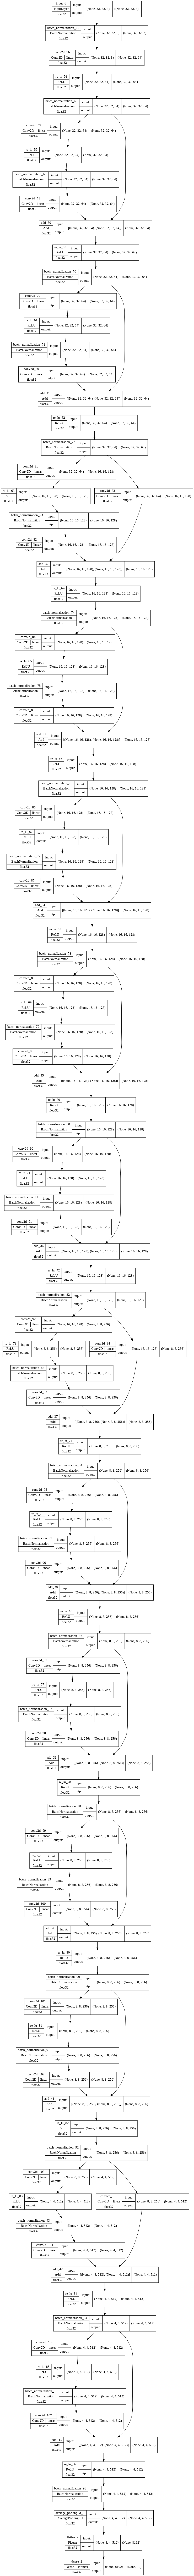

In [ ]:
plot_model(model_1, show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None, show_layer_activations=True)

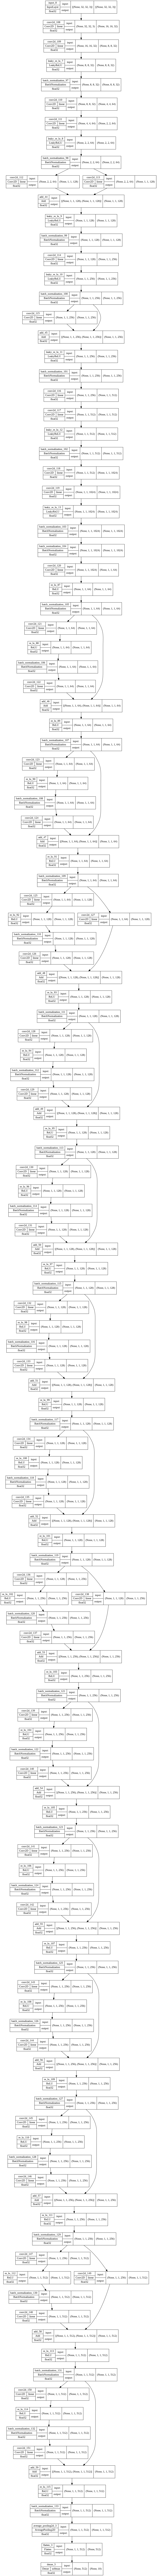

In [ ]:
plot_model(model_2, show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None, show_layer_activations=True)

In [ ]:
model = Model([model_1.input, model_2.input], [model_1.output, model_2.output])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

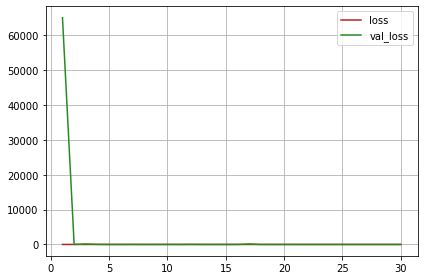

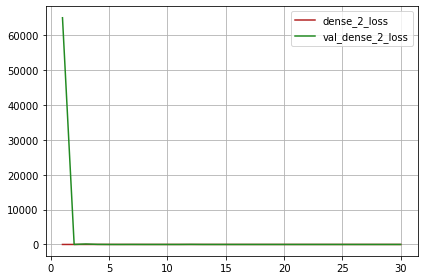

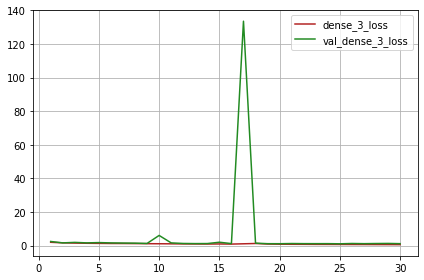

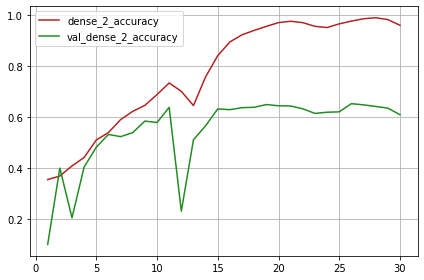

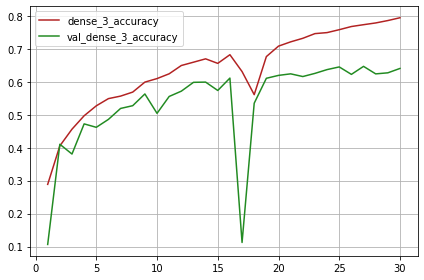

196/196 [==============================] - 255s 1s/step - loss: 0.7150 - dense_2_loss: 0.1216 - dense_3_loss: 0.5934 - dense_2_accuracy: 0.9599 - dense_3_accuracy: 0.7949 - val_loss: 3.6672 - val_dense_2_loss: 2.4962 - val_dense_3_loss: 1.1710 - val_dense_2_accuracy: 0.6091 - val_dense_3_accuracy: 0.6409


In [ ]:
timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)
tf.config.run_functions_eagerly(True)

#x_train = random_crop(x_train, 20, 20)

history = model.fit(
    x = [x_train, x_train],
    y = [y_train, y_train],
    epochs = 30,
    verbose = 1,
    validation_data = ([x_test, x_test], [y_test, y_test]),
    batch_size = 256,
    callbacks = [cp_callback, tensorboard_callback, PlotLearning()]
)